# Titanic - Machine Learning from Disaster

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
train_data['data']=1
test_data['data']=0
test_data['Survived'] =np.NaN 
#Just adding columns in each training and test data to distinguish betweeen them and also a column Survived in test data indicating it is to be predicted.
combined_data = pd.concat([train_data,test_data]) 



In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  data         891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  data         418 non-null    int64  
 12  Survived     0 non-null      float64
dtypes: float64(3), int64(5), object(5)
memory usage: 42.6+ KB


Here, we can observe the features Age, Cabin and Embarked has null values.(Note that Embarked has only 2 missing values). A total of 177 rows in Age feature is missing and also 687 rows are missing in Cabin feature. Age can be filled by mean which I think will be more suitable here and for Cabin, we have to explore more so that we will see whether that coulumn is important. In test data the features Age, Cabin and fare has missing values , also note that fare has only one missing values. So while data cleaning we will do it for the combined data so that we have no null values in the entire dataset. Other than cabin feature, others can be filled by statistical measures,but Cabin has to be taken care of in a different way.

**Dealing with missing values**

In [5]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  data         1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 143.2+ KB


In [6]:
#Filling missing values for continous data
#Age - Imputing by passenger class as different passenger class had different median and mean for Age. 
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

combined_data['Age'] = combined_data[['Age','Pclass']].apply(impute_age,axis=1)    
    
#Fare
combined_data.Fare = combined_data.Fare.fillna(train_data.Fare.median())

In [7]:
combined_data[combined_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,data
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1


While exploring embarked feature,we can observe that both the passengers have been embarked from same por, since theeir tickedt number are same.While exploring the data, if the null values are filled with the 'most frequent' strategy, it will fill it as 'C', but in google it shows both of this passengers have embarked from port 'S'. So we will fill the embarked feature with 'S'. 

In [8]:
combined_data['Embarked'] = combined_data['Embarked'].fillna('S')

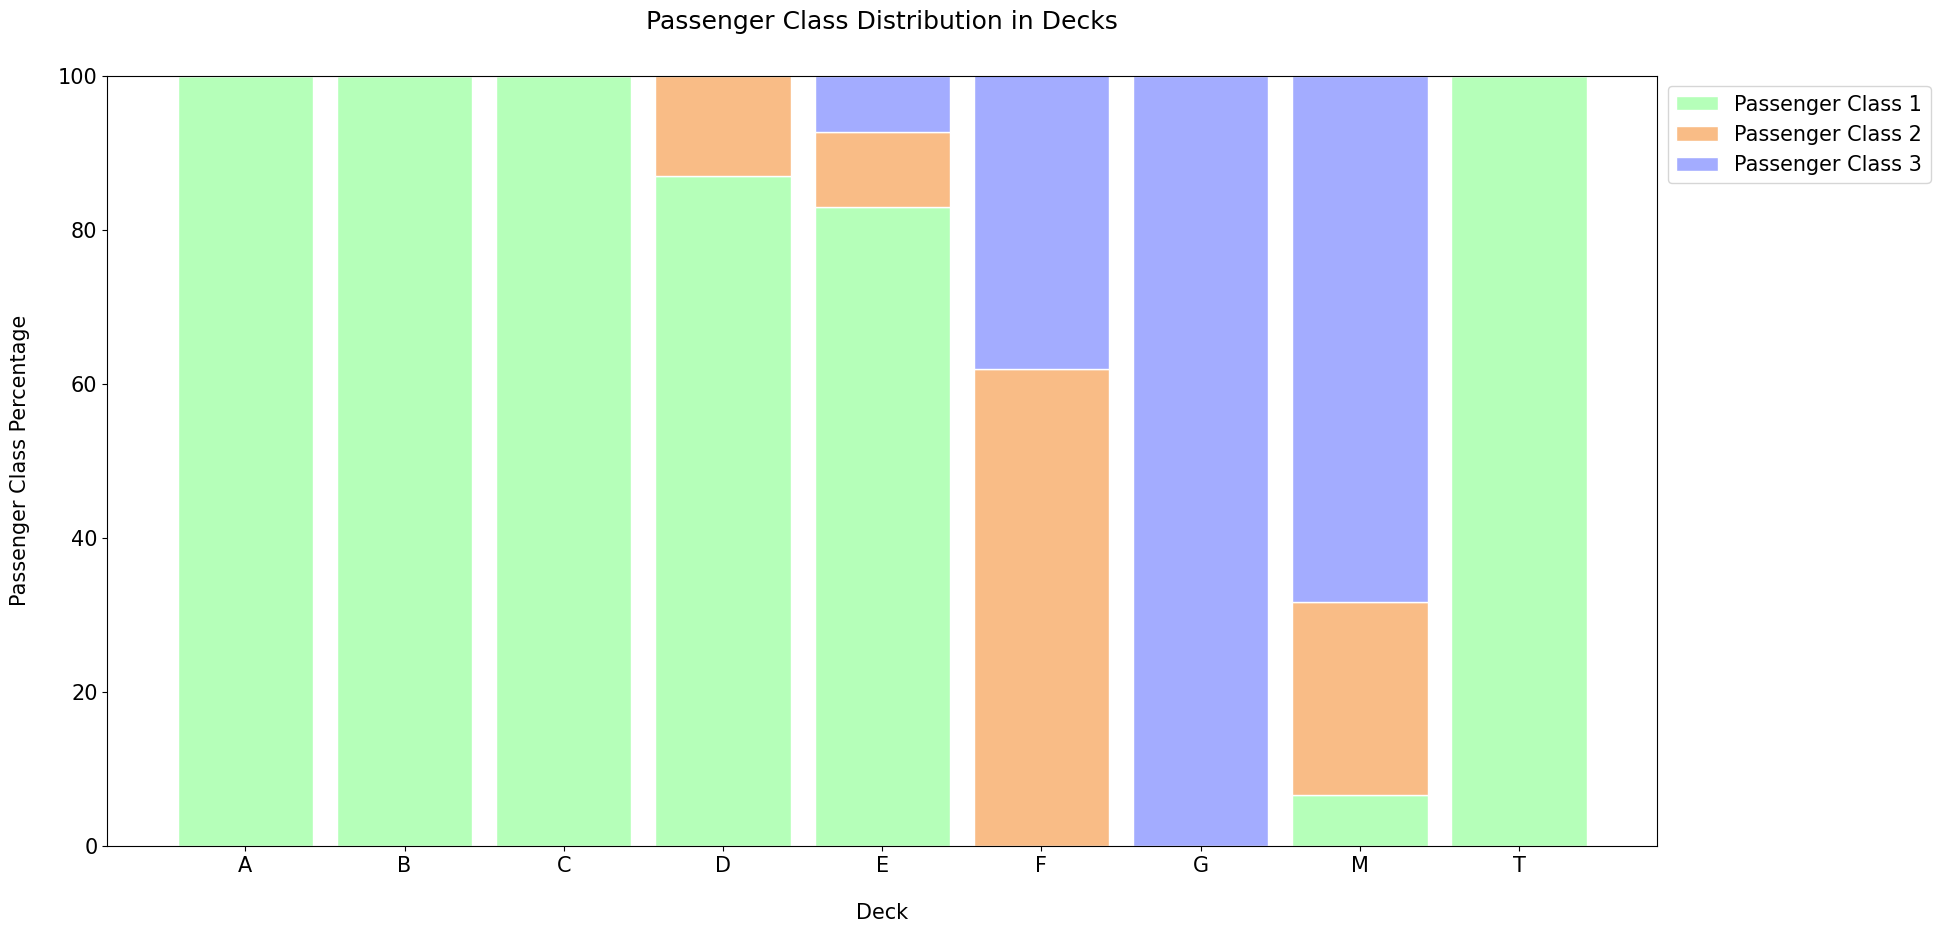

In [9]:
#Cabin cant be completely dropped because cabin and Pclass can be related and definitely Pclass will have a reelation with survival rate. Here, it is somewhat advanced feature engineering and I had 
#taken some reference from Gunes Evitan 
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
#On the Boat Deck there were 6 rooms labeled as T, U, W, X, Y, Z but only the T cabin is present in the dataset
#A, B and C decks were only for 1st class passengers
#D and E decks were for all classes
#F and G decks were for both 2nd and 3rd class passengers
#From going A to G, distance to the staircase increases which might be a factor of survival

combined_data['Deck'] =combined_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

combined_data_decks = combined_data.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(combined_data_decks)
display_pclass_dist(all_deck_per)

* 100% of A, B and C decks are 1st class passengers
* Deck D has 87% 1st class and 13% 2nd class passengers
* Deck E has 83% 1st class, 10% 2nd class and 7% 3rd class passengers
* Deck F has 62% 2nd class and 38% 3rd class passengers
* 100% of G deck are 3rd class passengers
* There is one person on the boat deck in T cabin and he is a 1st class passenger. T cabin passenger has the closest resemblance to A deck passengers so he is grouped with A deck
Passengers labeled as M are the missing values in Cabin feature. I don't think it is possible to find those passengers' real Deck so I decided to use M like a deck

In [10]:
# Passenger in the T deck is changed to A
idx = combined_data[combined_data['Deck'] == 'T'].index
combined_data.loc[idx, 'Deck'] = 'A'

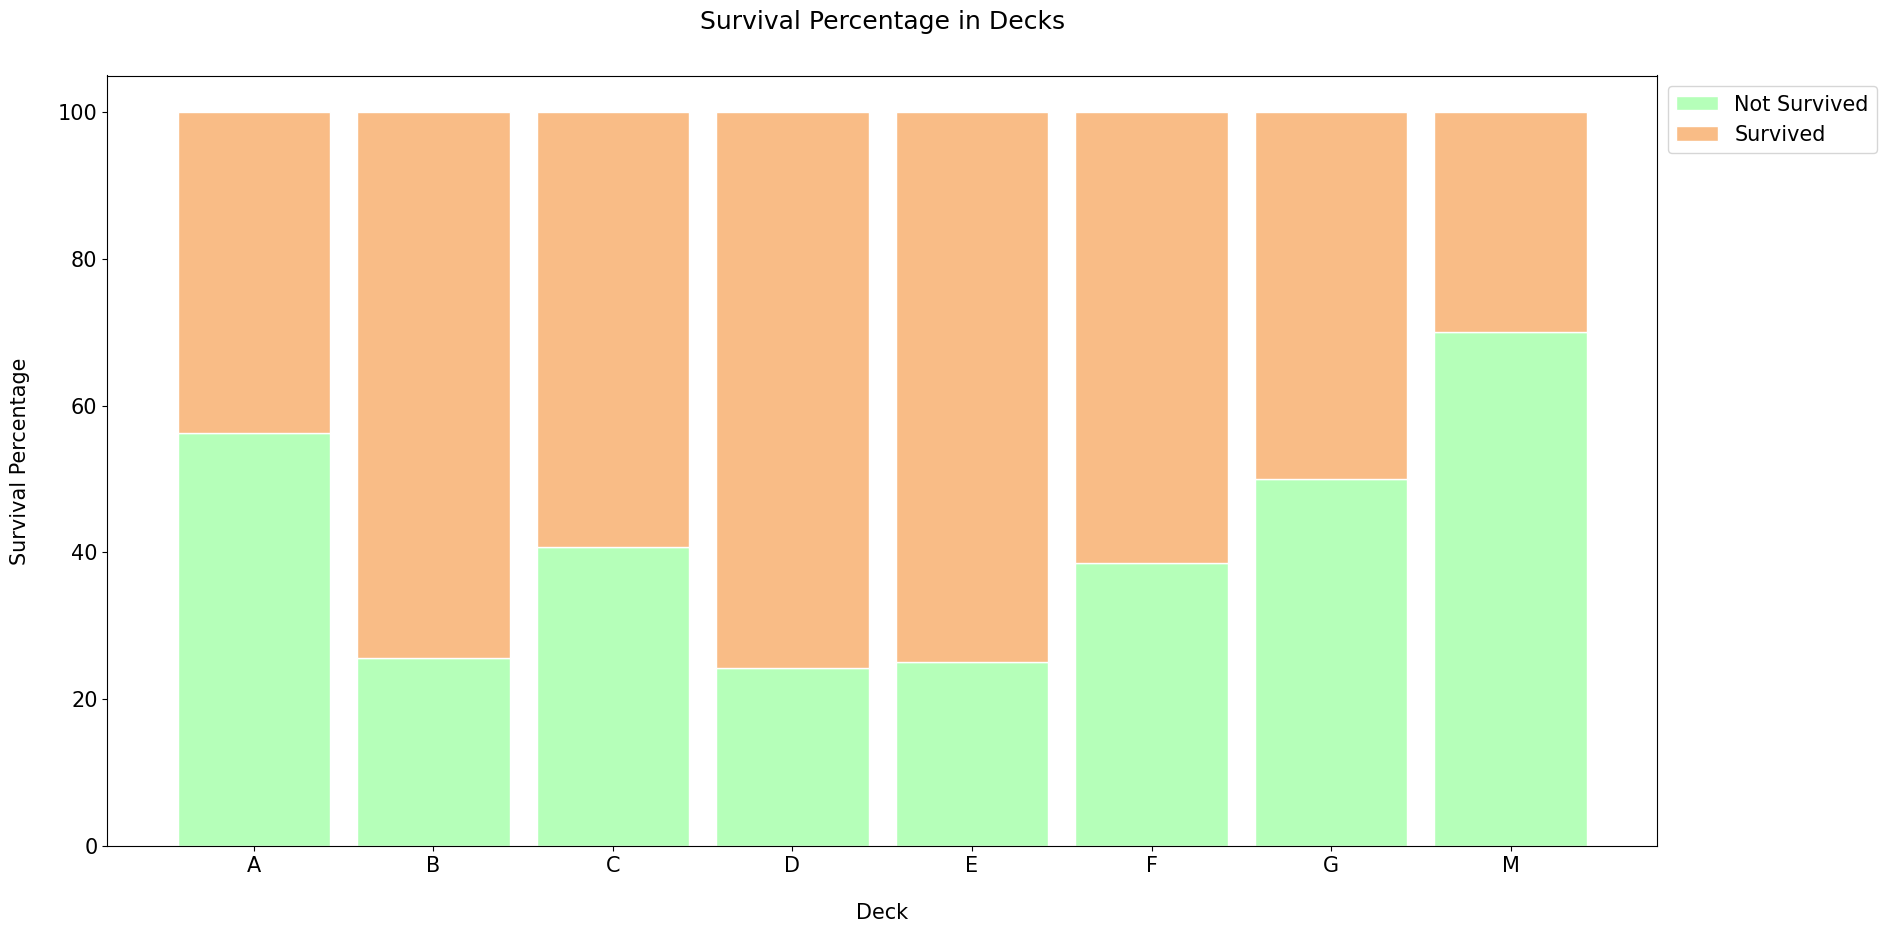

In [11]:
combined_data_survived = combined_data.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(combined_data_survived)
display_surv_dist(all_surv_per)

As I suspected, every deck has different survival rates and that information can't be discarded. Deck B, C, D and E have the highest survival rates. Those decks are mostly occupied by 1st class passengers. M has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers. To conclude, cabins used by 1st class passengers have higher survival rates than cabins used by 2nd and 3rd class passengers. In my opinion M (Missing Cabin values) has the lowest survival rate because they couldn't retrieve the cabin data of the victims. That's why I believe labeling that group as M is a reasonable way to handle the missing data. It is a unique group with shared characteristics. Deck feature has high-cardinality right now so some of the values are grouped with each other based on their similarities.

* A, B and C decks are labeled as ABC because all of them have only 1st class passengers
* D and E decks are labeled as DE because both of them have similar passenger class distribution and same survival rate
* F and G decks are labeled as FG because of the same reason above
* M deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [12]:
combined_data['Deck'] =combined_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
combined_data['Deck'] =combined_data['Deck'].replace(['D', 'E'], 'DE')
combined_data['Deck'] =combined_data['Deck'].replace(['F', 'G'], 'FG')

combined_data['Deck'].value_counts()

M      1013
ABC     183
DE       87
FG       26
Name: Deck, dtype: int64

In [13]:
# Dropping the Cabin feature
combined_data.drop(['Cabin'], inplace=True, axis=1)


In [14]:
combined_data['numeric_ticket'] = combined_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
combined_data['ticket_letters'] = combined_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
combined_data['name_title'] = combined_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
combined_data['norm_fare'] = np.log(combined_data.Fare+1)
combined_data.Pclass = combined_data.Pclass.astype(str)

In [15]:
combined_dummies = pd.get_dummies(combined_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','Deck','numeric_ticket','name_title','data']])
X_train = combined_dummies[combined_dummies.data == 1].drop(['data'], axis =1)
X_test = combined_dummies[combined_dummies.data == 0].drop(['data'], axis =1)
y_train = combined_data[combined_data.data==1].Survived
y_train.shape

(891,)

# Scaling the Data

In [16]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
combined_dummies_scaled = combined_dummies.copy()
combined_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(combined_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
combined_dummies_scaled

X_train_scaled = combined_dummies_scaled[combined_dummies_scaled.data == 1].drop(['data'], axis =1)
X_test_scaled = combined_dummies_scaled[combined_dummies_scaled.data == 0].drop(['data'], axis =1)

y_train = combined_data[combined_data.data==1].Survived

# Model Building

In [17]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score


In [18]:
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.81564246 0.80898876 0.86516854 0.80898876 0.84831461]
0.8294206264515724


In [19]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.84357542 0.81460674 0.83146067 0.80337079 0.85393258]
0.8293892411022534


In [20]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('svc',svc),('xgb',xgb)], voting = 'soft') 
cv = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.84916201 0.81460674 0.84269663 0.79213483 0.86516854]
0.8327537505492435


In [21]:
voting_clf.fit(X_train_scaled,y_train)
y_pred = voting_clf.predict(X_test_scaled).astype(int)
basic_submission = {'PassengerId': test_data.PassengerId, 'Survived': y_pred}
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

# Model Tuning

In [22]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [23]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


In [24]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [25]:
best_svc = best_clf_svc.best_estimator_
best_xgb = best_clf_xgb.best_estimator_

In [26]:
voting_clf_final = VotingClassifier(estimators = [('svc',best_svc), ('xgb', best_xgb)], voting = 'soft')
voting_clf_final.fit(X_train_scaled, y_train)
y_pred_final = voting_clf_final.predict(X_test_scaled).astype(int)

In [27]:
final_data = {'PassengerId': test_data.PassengerId, 'Survived': y_pred_final}
submission = pd.DataFrame(data=final_data)
print(submission)
submission.to_csv('submission_final.csv', index =False)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
